# Forecasting Stock Prices using XGBoost
### A Step-By-Step Walk-Through

Yibin Ng. Oct 26, 2019. [Here](https://towardsdatascience.com/forecasting-stock-prices-using-xgboost-a-detailed-walk-through-7817c1ff536a).[Code](https://github.com/NGYB/Stocks/blob/master/StockPricePrediction/StockPricePrediction_v4a_lstm.ipynb) [Main Code](https://github.com/NGYB/Stocks/tree/master/StockPricePrediction)

There are many machine learning techniques in the wild, but extreme gradient boosting (XGBoost) is one of the most popular. Gradient boosting is a process to convert weak learners to strong learners, in an iterative fashion. The name XGBoost refers to the engineering goal to push the limit of computational resources for boosted tree algorithms. Ever since its introduction in 2014, XGBoost has proven to be a very powerful machine learning technique and is usually the go-to algorithm in many Machine Learning competitions.

In this article, we will experiment with using XGBoost to forecast stock prices. We have experimented with XGBoost in a previous article [Here](https://towardsdatascience.com/machine-learning-techniques-applied-to-stock-price-prediction-6c1994da8001), but in this article, we will be taking a more detailed look at the performance of XGBoost applied to the stock price prediction problem. We list down the main differences between this article and the previous one below:

- In the previous article, we predict only for **1 day**, but here we predict for the next 21 days (note there are about 21 trading days in a month, excluding weekends). To do so, we use a technique known as **recursive forecasting**.
- In the previous article, we used a simple train-validation-test split, but here we used the **moving window validation method** to perform hyperparameter tuning.
- In the previous article, the number of previous days to use as lag features (denoted as N) was treated as a hyperparameter to be tuned. But here we set N=14 and let the model infer for itself which lag period is more important for prediction.
- In the previous article, we used only the prices of the previous N days as features, but here we do more **feature engineering** and introduce more features.

In the rest of this article, we will walk through the standard steps of a machine learning project, with a focus on our stock price prediction problem:

1. Problem Statement
2. Exploratory Data Analysis
3. Training, Validation, Test split
4. Feature Engineering
5. Feature Scaling
6. Hyperparameter Tuning
7. Applying the Model
8. Findings

It is worthwhile to be aware that there are other steps of a machine learning project not mentioned here such as data cleaning (not an issue here), missing values imputation (no missing values here), and feature selection (well, we don’t have a lot of features here). These topics are important as well, but are not an issue in our problem, as you will see below.

## 1. Problem Statement

It is very important to define the problem statement clearly before you start any work. Here, we aim to predict the daily adjusted closing prices of Vanguard Total Stock Market ETF (VTI), using data from the previous N days. In this experiment, we will use **6 years of historical prices for VTI from 2013–01–02 to 2018–12–28**, which can be easily downloaded from yahoo finance. After downloading, the dataset looks like this:

In [1]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
#from tensorflow import set_random_seed
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model


Using TensorFlow backend.


In [2]:
#### Input params ##################
stk_path = ".\\data\\vti.data.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set

N = 9                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. 
                               # initial value before tuning
lstm_units=50                  # lstm param. initial value before tuning.
dropout_prob=1                 # lstm param. initial value before tuning.
optimizer='adam'               # lstm param. initial value before tuning.
epochs=1                       # lstm param. initial value before tuning.
batch_size=1                   # lstm param. initial value before tuning.

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Set seeds to ensure same output results
seed(101)
tf.random.set_seed(model_seed) # set_random_seed(model_seed)

In [3]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
def get_x_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

In [5]:
def get_x_scaled_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    We scale x to have mean 0 and std dev 1, and return this.
    We do not scale y here.
    Inputs
        data     : pandas series to extract x and y
        N
        offset
    Outputs
        x_scaled : features used to predict y. Scaled such that each element has mean 0 and std dev 1
        y        : target values. Not scaled
        mu_list  : list of the means. Same length as x_scaled and y
        std_list : list of the std devs. Same length as x_scaled and y
    """
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i]-mu_list[i-offset])/std_list[i-offset])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list

In [6]:
def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv, \
                          mu_cv_list, \
                          std_cv_list, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use LSTM here.
    Returns rmse, mape and predicted values
    Inputs
        x_train_scaled  : e.g. x_train_scaled.shape=(451, 9, 1). Here we are using the past 9 values to predict the next value
        y_train_scaled  : e.g. y_train_scaled.shape=(451, 1)
        x_cv_scaled     : use this to do predictions 
        y_cv            : actual value of the predictions
        mu_cv_list      : list of the means. Same length as x_scaled and y
        std_cv_list     : list of the std devs. Same length as x_scaled and y 
        lstm_units      : lstm param
        dropout_prob    : lstm param
        optimizer       : lstm param
        epochs          : lstm param
        batch_size      : lstm param
    Outputs
        rmse            : root mean square error
        mape            : mean absolute percentage error
        est             : predictions
    '''
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Do prediction
    est_scaled = model.predict(x_cv_scaled)
    est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
    
    # Calculate RMSE and MAPE
#     print("x_cv_scaled = " + str(x_cv_scaled))
#     print("est_scaled = " + str(est_scaled))
#     print("est = " + str(est))
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est

## 2. Exploratory Data Analysis

In [7]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2015-11-25,107.510002,107.660004,107.250000,107.470001,101.497200,1820300,11
1,2015-11-27,107.589996,107.760002,107.220001,107.629997,101.648300,552400,11
2,2015-11-30,107.779999,107.849998,107.110001,107.169998,101.213867,3618100,11
3,2015-12-01,107.589996,108.209999,107.370003,108.180000,102.167740,2443600,12
4,2015-12-02,108.099998,108.269997,106.879997,107.050003,101.100533,2937200,12


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755 entries, 0 to 754
Data columns (total 8 columns):
date         755 non-null datetime64[ns]
open         755 non-null float64
high         755 non-null float64
low          755 non-null float64
close        755 non-null float64
adj_close    755 non-null float64
volume       755 non-null int64
month        755 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 53.1 KB


Altogether, we have 1509 days of data to play with. Note that Saturdays and Sundays are not included in the dataset above. A plot of the adjusted closing price in the entire dataset is shown below:

Text(0, 0.5, 'USD')

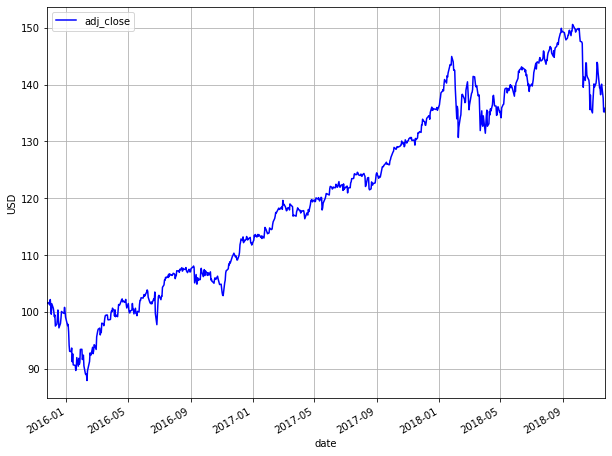

In [9]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

To effectively evaluate the performance of XGBoost, running one forecast at a single date is not enough. Instead, we will perform various forecasts at different dates in this dataset, and average the results.

To evaluate the effectiveness of our methods, we will use the root mean square error (RMSE), mean absolute percentage error (MAPE) and mean absolute error (MAE) metrics. For all metrics, the lower the value, the better the prediction. Similar to our previous article, we will use the Last Value method to benchmark our results.

### Exploratory Data Analysis (EDA)

EDA is an essential part of a machine learning project to help you get a good ‘feel’ for a dataset. If you participate in Machine Learning competitions (or plan to), extensive EDA may help you generate better features or even discover ‘information leaks’ which can help you climb the leaderboard rankings. As we will see below, the EDA process involves creating visualizations to help you understand the dataset better.

The plot below shows the average adjusted closing price for each month. We can infer that based on our dataset, on average, later months have a higher value than earlier months.

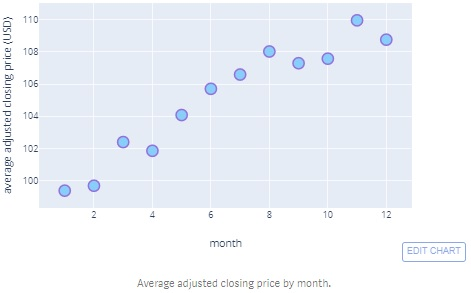

In [ ]:
## Average adjusted closing price by month.

The plot below shows the average adjusted closing price for each day of the month. On average, there is an upward sloping trend, where the later days of the month have a higher price than the earlier days.

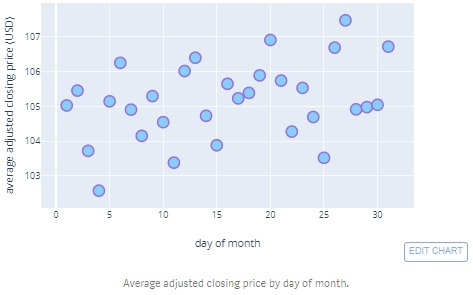

In [ ]:
## Average adjusted closing price by day of month.

The plot below shows the average adjusted closing price for each day of the week. On average, adjusted closing prices are higher for Thursdays and Fridays than other days of the week.

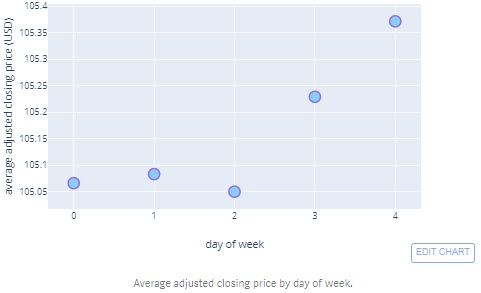

In [ ]:
## Average adjusted closing price by day of week.

The heatmap below shows the correlation of previous days’ adjusted closing prices with the current day’s. It is clear that the nearer the adjusted closing price is to the current day, the more highly correlated they are. Therefore, features relating to adjusted closing prices of the previous 10 days should be used in the prediction.

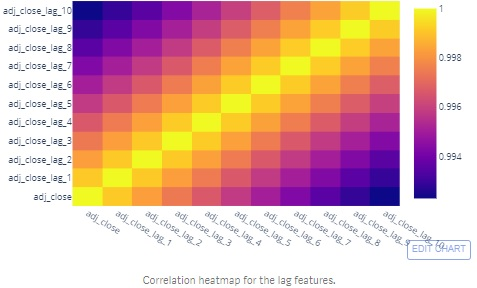

Based on the EDA above, we infer that features related to dates might be helpful to the model. Further, adjusted closing prices of the previous 10 days are highly correlated to the target variable. These are important information that we will use for feature engineering below.

In [28]:
## Correlation heatmap for the lag features.

## 4. Feature Engineering

Feature engineering is a creative process and is one of the most important parts of any machine learning project. To highlight the importance of feature engineering, there is a nice quote from Andrew Ng which is worth sharing (from Wikipedia):

**Coming up with features is difficult, time-consuming, requires expert knowledge. “Applied machine learning” is basically feature engineering**. — `Andrew Ng, Machine Learning and AI via Brain simulations`

In this project, we will generate the following features:

Adjusted closing prices of the last N=10 days

- *year*
- *month*
- *week*
- *dayofmonth*
- *dayofweek*
- *dayofyear*
- *is_month_end*
- *is_month_start*
- *is_quarter_end*
- *is_quarter_start*
- *is_year_end*
- *is_year_start*

The features relating to dates are easily generated using the fastai package as such:

In [10]:
from fastai.tabular import add_datepart

add_datepart(df, 'date', drop=False)
df.drop('Elapsed', axis=1, inplace=True)  # don't need this

df.head()

,date,open,high,low,close,adj_close,volume,month,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2015-11-25,107.510002,107.660004,107.250000,107.470001,101.497200,1820300,11,2015,11,48,25,2,329,False,False,False,False,False,False
1,2015-11-27,107.589996,107.760002,107.220001,107.629997,101.648300,552400,11,2015,11,48,27,4,331,False,False,False,False,False,False
2,2015-11-30,107.779999,107.849998,107.110001,107.169998,101.213867,3618100,11,2015,11,49,30,0,334,True,False,False,False,False,False
3,2015-12-01,107.589996,108.209999,107.370003,108.180000,102.167740,2443600,12,2015,12,49,1,1,335,False,True,False,False,False,False
4,2015-12-02,108.099998,108.269997,106.879997,107.050003,101.100533,2937200,12,2015,12,49,2,2,336,False,False,False,False,False,False


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755 entries, 0 to 754
Data columns (total 20 columns):
date                755 non-null datetime64[ns]
open                755 non-null float64
high                755 non-null float64
low                 755 non-null float64
close               755 non-null float64
adj_close           755 non-null float64
volume              755 non-null int64
month               755 non-null int64
Year                755 non-null int64
Month               755 non-null int64
Week                755 non-null int64
Day                 755 non-null int64
Dayofweek           755 non-null int64
Dayofyear           755 non-null int64
Is_month_end        755 non-null bool
Is_month_start      755 non-null bool
Is_quarter_end      755 non-null bool
Is_quarter_start    755 non-null bool
Is_year_end         755 non-null bool
Is_year_start       755 non-null bool
dtypes: bool(6), datetime64[ns](1), float64(5), int64(8)
memory usage: 92.9 KB


After using the code above the dataframe looks like the above. The column adj_close will be the target column. Features relating to adjusted closing prices of the last N days are omitted for brevity.

The heatmap below shows the correlation of the features with the target column. The feature year is quite highly correlated with the adjusted closing price. This is unsurprising, because in our dataset, there is an upward-sloping trend where the larger the year, the higher the adjusted closing price. Other features do not exhibit a high correlation with the target variable. From the below, we also found that the feature is_year_start has all NaNs. This is because the first day of the year is never a trading day, and so we remove this feature from the model.

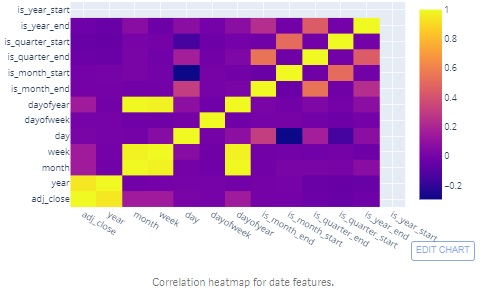

Below is a bar chart showing the importance scores of the top 10 most important features. This is obtained for the forecast of 2017–01–03, and forecasts on other dates may have different ranking of the feature importance. As expected, the adjusted closing price of the previous day is the most important feature.

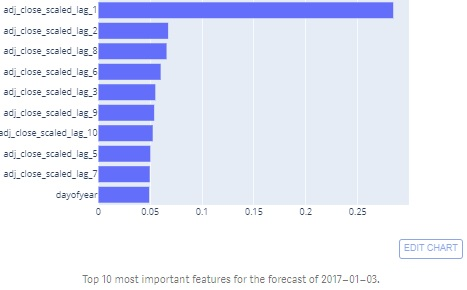

## 3. Training, Validation, Test split

To perform a forecast, we need training and validation data. We will use 3 years of data as the train set, which corresponds to 756 days since there are about 252 trading days in a year (252*3 = 756). We will use the next 1 year of data to perform validation, which corresponds to 252 days. In other words, for each forecast we make, we need 756+252 = 1,008 days of data for model training and validation. The model will be trained using the train set, and model hyperparameters will be tuned using the validation set.

To tune the hyperparameters, we will use the moving window validation method. The moving window validation method has been described in detail in one of our previous [articles](https://towardsdatascience.com/forecasting-stock-prices-using-prophet-652b31fb564e)

An example is illustrated below, for the case of train size of 756 days, validation size of 40 days, and a forecast horizon of 40 days.

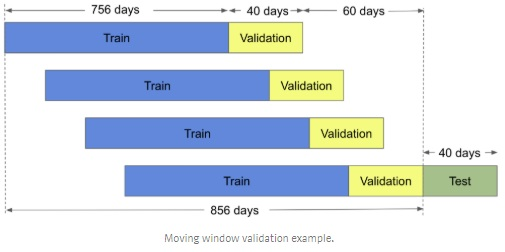

It is very important in time series prediction that the train, validation, test splits have to be in chronological order. Failure to do so will result in ‘**information leak**’ in the model, which is defined as the scenario where the model is trained on data that provides information about the test set. 

For example, if we have the open price for today and we are trying to predict for the closing price yesterday, immediately we can set our prediction to be equal to the open price of today and we should get pretty good results. The end result is that our model will give better performance than can be expected in real life. Therefore, when building a machine learning model, we need to be very careful about information leaks.

In what follows, we will use XGBoost to perform forecasts on several days in our test set, namely:
- 2017–01–03
- 2017–03–06
- 2017–05–04
- 2017–07–05
- 2017–09–01
- 2017–11–01
- 2018–01–03
- 2018–03–06
- 2018–05–04
- 2018–07–05
- 2018–09–04
- 2018–11–01

For each of the 12 forecasts above, we will use a forecast horizon of 21 days. We will use the 1008 days immediately prior to the forecast date as training and validation set, with a 756:252 split as mentioned above.

We use lags up to N number of days to use as features.

In [12]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train][['date', 'adj_close']]
cv = df[num_train:num_train+num_cv][['date', 'adj_close']]
train_cv = df[:num_train+num_cv][['date', 'adj_close']]
test = df[num_train+num_cv:][['date', 'adj_close']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 453
num_cv = 151
num_test = 151
train.shape = (453, 2)
cv.shape = (151, 2)
train_cv.shape = (604, 2)
test.shape = (151, 2)


## 5. Feature Scaling
Feature scaling is important here because if you were to look at the plot of adjusted closing prices above, splitting the train and test sets in a chronological split almost always results in the **adjusted closing prices of the test set having a higher value than the train set**. What this means is that a model trained without scaling the adjusted closing prices will only output predictions around the range of the prices in the train set. This has also been explained in our previous [article](https://towardsdatascience.com/machine-learning-techniques-applied-to-stock-price-prediction-6c1994da8001)

We have experimented with various techniques and in this article, we will use the method found from the above that has the best performance. For each feature group of adjusted closing prices (the lag features) of each sample, we will scale them to have mean 0 and variance 1. For example, if we are doing predictions on day T, we will take the adjusted closing prices of the last N days (days T-N to T-1) and scale them to have mean 0 and variance 1. The same is done on the train, validation, and test sets for the lag features. The date features are not scaled. We then use these scaled lag features and dates features to do prediction. The predicted values will also be scaled and we inverse transform them using their corresponding mean and variance.

In [33]:
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['adj_close']).reshape(-1,1))
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))

# Split into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape)) # (446, 7, 1)
print("y_train_scaled.shape = " + str(y_train_scaled.shape)) # (446, 1)

scaler.mean_ = [109.092171]
scaler.var_ = [95.199022]
x_train_scaled.shape = (444, 9, 1)
y_train_scaled.shape = (444, 1)


In [34]:
# Scale the cv dataset
# Split into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['adj_close']).reshape(-1,1), N, num_train)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("len(mu_cv_list) = " + str(len(mu_cv_list)))
print("len(std_cv_list) = " + str(len(std_cv_list)))

x_cv_scaled.shape = (151, 9, 1)
y_cv.shape = (151, 1)
len(mu_cv_list) = 151
len(std_cv_list) = 151


In [36]:
# Here we scale the train_cv set, for the final model
scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['adj_close']).reshape(-1,1))
print("scaler_final.mean_ = " + str(scaler_final.mean_))
print("scaler_final.var_ = " + str(scaler_final.var_))

# # Scale the test dataset
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['adj_close']).reshape(-1,1), N, num_train+num_cv)
print("x_test_scaled.shape = " + str(x_test_scaled.shape))
print("y_test.shape = " + str(y_test.shape))
print("len(mu_test_list) = " + str(len(mu_test_list)))
print("len(std_test_list) = " + str(len(std_test_list)))

scaler_final.mean_ = [115.382945]
scaler_final.var_ = [195.780428]
x_test_scaled.shape = (151, 9, 1)
y_test.shape = (151, 1)
len(mu_test_list) = 151
len(std_test_list) = 151


## 6. Hyperparameter Tuning

We perform hyperparameter tuning on the validation set. For XGBoost, there are several hyperparameters that can be tuned including n_estimators, max_depth, learning_rate, min_child_weight, subsample, gamma, colsample_bytree, and colsample_bylevel. For a definition of each of these hyperparameters, see [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn).

To look at the effectiveness of hyperparameter tuning, we can look at the predictions on our validation set for the forecast of 2018–11–01. Below show the predictions without hyperparameter tuning, where we just use the default values from the package:

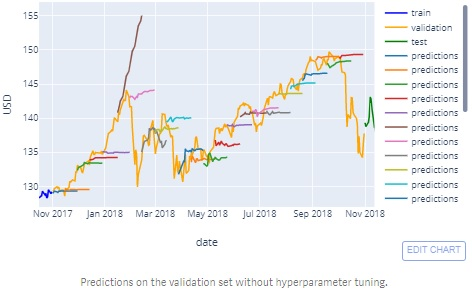


Below shows the predictions on the same validation set after hyperparameter tuning. You can see the wild prediction on 18 Jan is much more stable now.

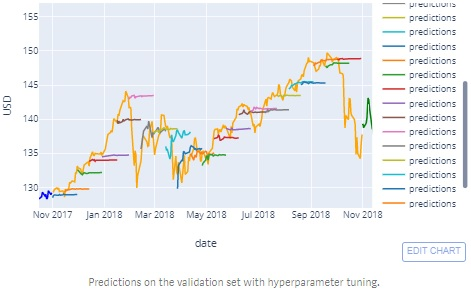

Below shows the hyperparameters before and after tuning:

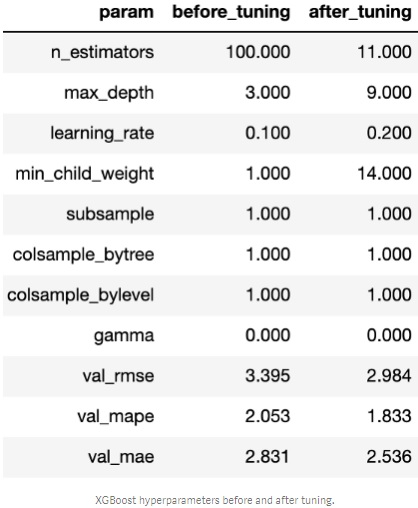

Clearly, the tuned hyperparameters differ a lot from the default values. Also, after tuning the RMSE, MAPE and MAE of the validation drops as expected. For example, RMSE drops from 3.395 to 2.984.

### Create and fit the LSTM network

In [37]:
# Create the LSTM network
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/1
 - 7s - loss: 0.0561


In [38]:
# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 9, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Plot model and save to file
# pip install pydot
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='model_v4a.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [42]:
# Do prediction
est_scaled = model.predict(x_cv_scaled)
est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
print("est.shape = " + str(est.shape))

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, est))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv, est)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

est.shape = (151, 1)
RMSE = 2.262
MAPE = 1.156%


Text(0, 0.5, 'USD')

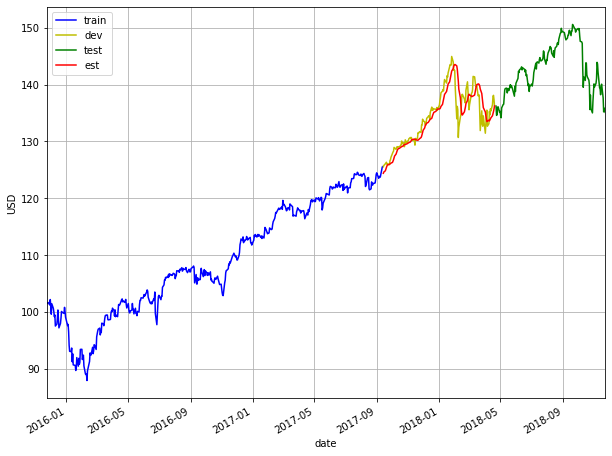

In [43]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'y_cv': y_cv.reshape(-1),
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

### Tuning N (no. of days to use as features)

In [44]:
param_label = 'N'
param_list = range(3, 60)

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    # Split train into x and y
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)

    # Split cv into x and y
    x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['adj_close']).reshape(-1,1), param, num_train)
    
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units, \
                                          dropout_prob=dropout_prob, \
                                          optimizer=optimizer, \
                                          epochs=epochs, \
                                          batch_size=batch_size)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate


Minutes taken = 21.30454816420873


,N,rmse,mape_pct
0,3,1.580194,0.799832
1,4,1.721678,0.885795
2,5,1.958481,1.002561
3,6,2.021243,1.016604
4,7,2.107841,1.066612
5,8,2.246180,1.164449
6,9,2.225065,1.155352
7,10,2.306908,1.217329
8,11,2.272911,1.198052
9,12,2.321703,1.206601


Text(0, 0.5, 'RMSE/MAPE(%)')

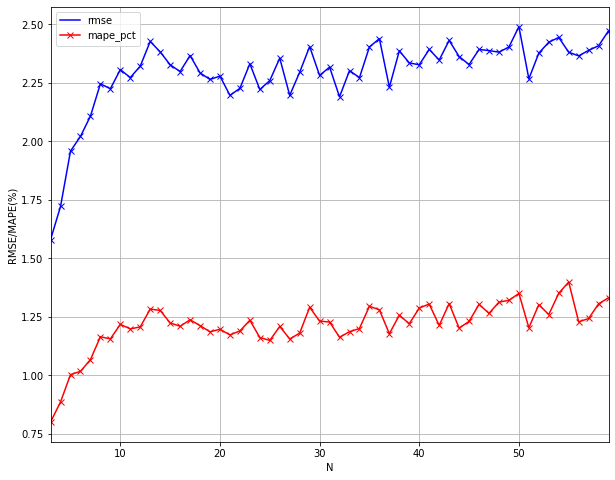

In [45]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [46]:
# Get optimum value for param
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 1.580
min MAPE = 0.800%
optimum N = 3


### Tuning model - epochs and batch_size

In [47]:
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

# Split train into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

# Split cv into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['adj_close']).reshape(-1,1), N_opt, num_train)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv, \
                                              mu_cv_list, \
                                              std_cv_list, \
                                              lstm_units=lstm_units, \
                                              dropout_prob=dropout_prob, \
                                              optimizer=optimizer, \
                                              epochs=param, \
                                              batch_size=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate



Minutes taken = 4.558943649133046


,N,batch_size,rmse,mape_pct
0,1,8,1.620029,0.833227
1,1,16,1.487822,0.748962
2,1,32,1.439294,0.718730
3,1,64,1.418095,0.706644
4,1,128,1.412417,0.704563
5,10,8,1.565027,0.785540
6,10,16,1.580163,0.797629
7,10,32,1.582829,0.799648
8,10,64,1.593054,0.806783
9,10,128,1.610240,0.814479


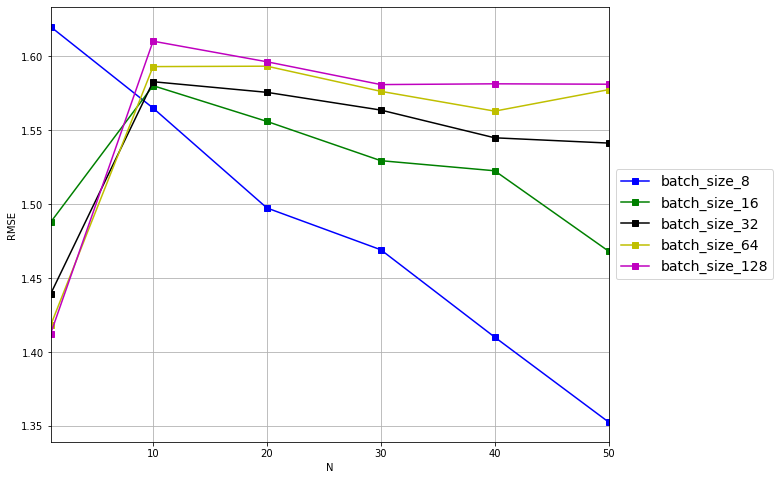

In [48]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

In [49]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

min RMSE = 1.353
min MAPE = 0.665%
optimum N = 50
optimum batch_size = 8


### Tuning model - LSTM units and dropout prob

In [50]:
param_list = [10, 50, 64, 128]

param2_label = 'dropout_prob'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv, \
                                              mu_cv_list, \
                                              std_cv_list, \
                                              lstm_units=param, \
                                              dropout_prob=param2, \
                                              optimizer=optimizer, \
                                              epochs=epochs_opt, \
                                              batch_size=batch_size_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate



Minutes taken = 12.384497471650441


,N,dropout_prob,rmse,mape_pct
0,10,0.5,1.576368,0.796156
1,10,0.6,1.551340,0.779608
2,10,0.7,1.562142,0.785965
3,10,0.8,1.545406,0.772921
4,10,0.9,1.496493,0.745163
5,10,1.0,1.487493,0.744095
6,50,0.5,1.503798,0.748203
7,50,0.6,1.539874,0.772104
8,50,0.7,1.551665,0.779241
9,50,0.8,1.576849,0.795924


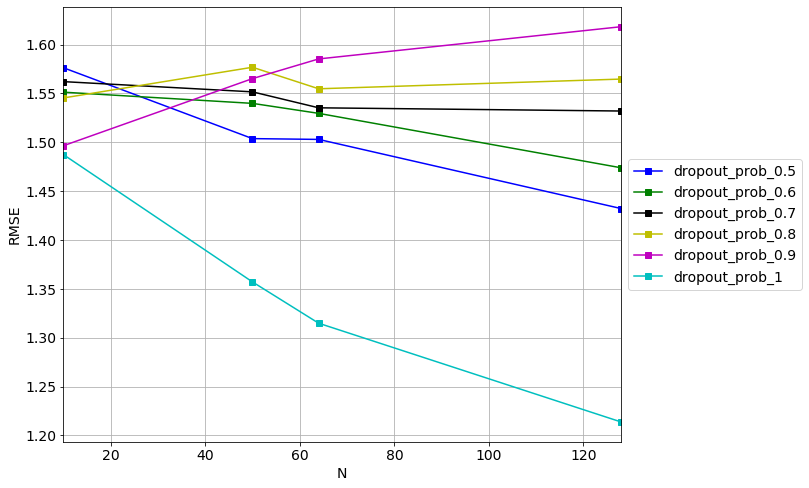

In [51]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [52]:
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param2_label + " = " + str(dropout_prob_opt))

min RMSE = 1.214
min MAPE = 0.587%
optimum N = 128
optimum dropout_prob = 1.0


### Tuning model - optimizer

In [53]:
param_label = 'optimizer'
param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
   
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units_opt, \
                                          dropout_prob=dropout_prob_opt, \
                                          optimizer=param, \
                                          epochs=epochs_opt, \
                                          batch_size=batch_size_opt)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate


Minutes taken = 5.074789031346639


,optimizer,rmse,mape_pct
0,adam,1.207405,0.587501
1,sgd,1.500467,0.750437
2,rmsprop,1.183939,0.579573
3,adagrad,1.427379,0.710580
4,adadelta,1.368610,0.678915
5,adamax,1.304151,0.636466
6,nadam,1.158053,0.572519


Text(0, 0.5, 'RMSE/MAPE(%)')

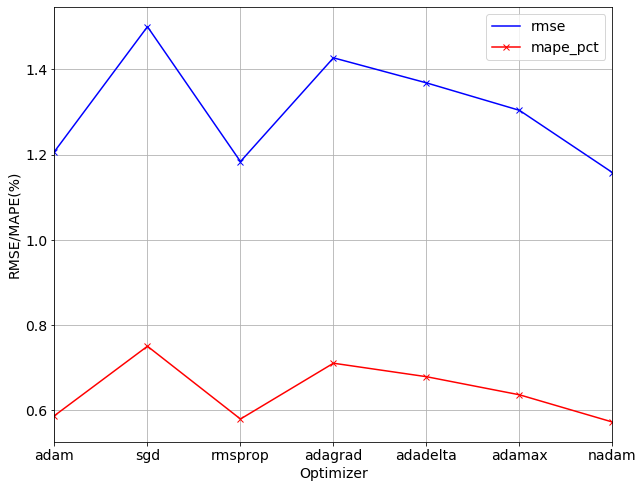

In [54]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='optimizer', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='optimizer', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xticklabels(param_list)
ax.set_xlabel("Optimizer")
ax.set_ylabel("RMSE/MAPE(%)")

In [55]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimizer_opt = temp[param_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimizer_opt))

min RMSE = 1.158
min MAPE = 0.573%
optimum optimizer = nadam


### Tuned params

In [56]:
d = {'param': ['N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size', 'rmse', 'mape_pct'],
     'original': [N, lstm_units, dropout_prob, optimizer, epochs, batch_size, rmse_bef_tuning, mape_pct_bef_tuning],
     'after_tuning': [N_opt, lstm_units_opt, dropout_prob_opt, optimizer_opt, epochs_opt, batch_size_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

,param,original,after_tuning
0,N,9,3
1,lstm_units,50,128
2,dropout_prob,1,1
3,optimizer,adam,nadam
4,epochs,1,50
5,batch_size,1,8
6,rmse,2.26166,1.15805
7,mape_pct,1.15588,0.572519


## 7. Applying the Model

Having performed EDA, feature engineering, feature scaling, and hyperparameter tuning as explained above, we are now ready to perform our forecasts on the test set. In this case, we have a forecast horizon of 21 days which means we need to generate 21 predictions for each forecast. **We cannot generate all 21 predictions at one go, because after generating the prediction for day T, we need to feedback this prediction into our model to generate the prediction for day T+1, and so on until we have all 21 predictions. This is known as recursive forecasting**. Therefore, we implement a logic like the flowchart below:

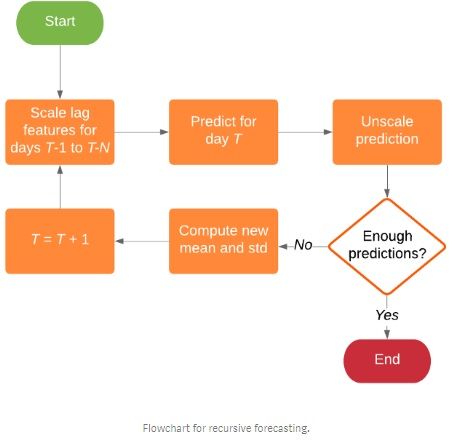

For each day in the forecast horizon, we need to predict, unscale the prediction, compute the new mean and standard deviation of the last N values, scale the adjusted closing prices of the last N days, and predict again.


### Final model

In [57]:
# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, N_opt, N_opt)

# Split test into x and y
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['adj_close']).reshape(-1,1), N_opt, num_train+num_cv)

# Train, predict and eval model
rmse, mape, est = train_pred_eval_model(x_train_cv_scaled, \
                                        y_train_cv_scaled, \
                                        x_test_scaled, \
                                        y_test, \
                                        mu_test_list, \
                                        std_test_list, \
                                        lstm_units=lstm_units_opt, \
                                        dropout_prob=dropout_prob_opt, \
                                        optimizer=optimizer_opt, \
                                        epochs=epochs_opt, \
                                        batch_size=batch_size_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 1.172
MAPE on test set = 0.585%


Text(0, 0.5, 'USD')

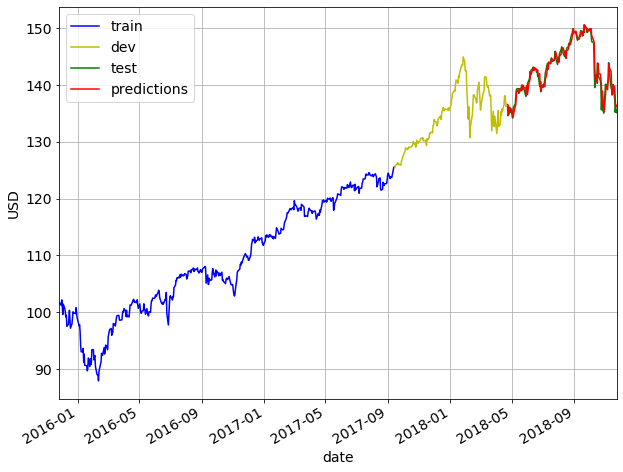

In [58]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[num_train+num_cv:]['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

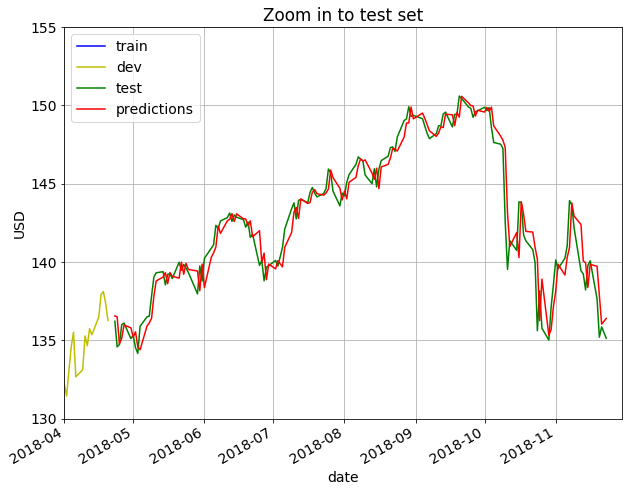

In [59]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 1), date(2018, 11, 30)])
ax.set_ylim([130, 155])
ax.set_title("Zoom in to test set")

(130, 155)

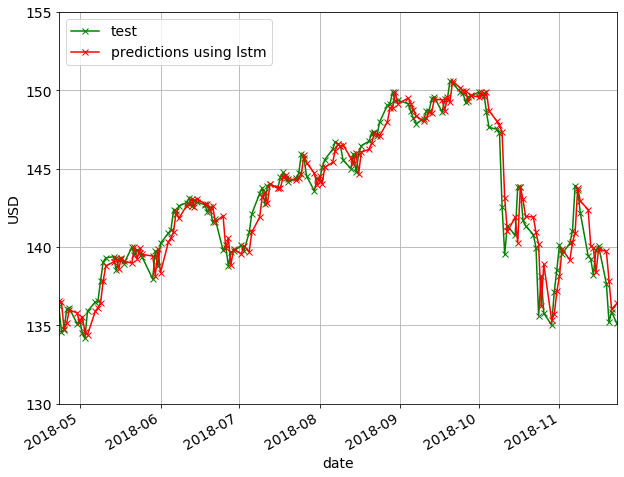

In [60]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using lstm'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 23), date(2018, 11, 23)])
ax.set_ylim([130, 155])

In [62]:
# Save as csv
test_lstm = est_df
test_lstm.to_csv(".\\output\\vti.output.data.csv")

## 8. Findings

Below shows the RMSE, MAPE, and MAE of each forecast, along with their corresponding (selected) optimum hyperparameters tuned using their respective validation sets.

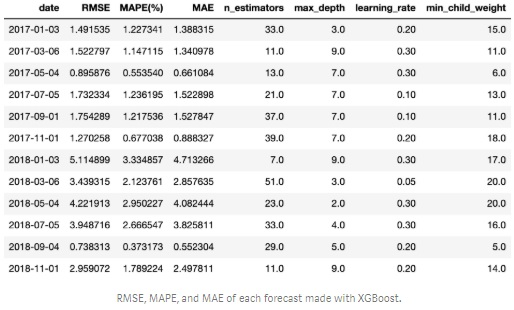

The results of applying XGBoost on our test set using the moving window validation method are shown below.

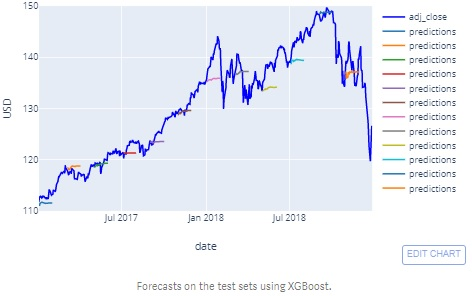

Another way of visualizing the forecasts is to plot each forecast with its actual value. This is shown in the plot below. If we have perfect accuracy, each forecast should lie on the diagonal y=x line.

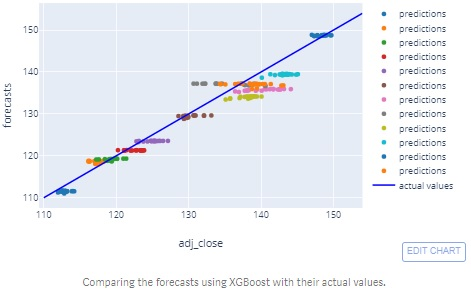

Finally, here are the results of our model benchmarked against the Last Value method:

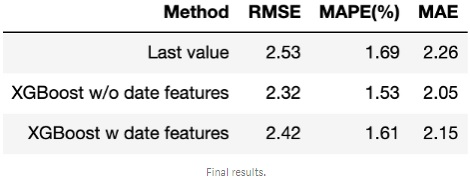

Using XGBoost with or without the date features give a better performance over the Last Value method. Interestingly, omitting the date features gives a slightly lower RMSE than including the date features (2.32 vs. 2.42). As we have found earlier, the date features have a low correlation with the target variable and likely do not help the model much.

You can check out the Jupyter notebooks for XGBoost without date features [here](https://github.com/NGYB/Stocks/blob/master/StockPricePrediction_fh21/StockPricePrediction_v6c_xgboost.ipynb), and XGBoost with date features [here](https://github.com/NGYB/Stocks/blob/master/StockPricePrediction_fh21/StockPricePrediction_v6d_xgboost.ipynb).

We hope you enjoyed the article above, where we worked and pondered through a real-life dataset rather than a simple textbook example. The intricacies of the recursive forecasting mechanism took us longer than expected, but it was fun. Another important point of this article is to show that there are many decisions to make in building a machine learning model, which makes it very much an art as well as a science. 

- On the test set, the RMSE is 1.164 and MAPE is 0.583% using N_opt=3